# Algoritmos de Machine Learning

En este Notebook, usaremos los Dataframes creados en el Notebook de Features para entrenar distintos modelos de Machine Learning y predecir si los tweets son reales o no.

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings 
warnings.filterwarnings('ignore')

## Carga de dataframes

In [36]:
train_df = pd.read_csv('../Data/train_features.csv', encoding='latin-1',dtype={'id': np.uint16,'target': np.bool})
test_df = pd.read_csv('../Data/test_features.csv', encoding='latin-1',dtype={'id': np.uint16})

In [37]:
train_df.head(2)

,id,target,cantidad_de_palabras,longitud_del_tweet,longitud_categ,tiene_menciones,es_expresivo,cantidad_de_hashtags,tiene_links,location_unico,keyword_encoded,tfidf_score
0,1,True,13,69,0.285554,False,False,1,False,False,0.527739,18.132632
1,4,True,7,38,0.285554,False,False,0,False,False,0.527739,39.483954


In [38]:
test_df.head(2)

,id,cantidad_de_palabras,longitud_del_tweet,longitud_categ,tiene_menciones,es_expresivo,cantidad_de_hashtags,tiene_links,location_unico,keyword_encoded,tfidf_score
0,0,6,34,0.285554,False,False,0,False,False,0.527739,74.111794
1,2,9,64,0.285554,False,False,1,False,False,0.527739,0.000000


## Algoritmos

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

### Random Forest

###### Entrenamiento

In [40]:
X = train_df.sort_values(by='id',ascending=True).iloc[:,2:]
Y = train_df.sort_values(by='id',ascending=True).iloc[:,1]

In [41]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2, random_state=1)

Esto es algo muy básico, se podría jugar más con los hiper-parámetros del RF pero de momento la prioridad va a ser crear features.

In [42]:
from sklearn.ensemble import RandomForestClassifier

accuracy = 0
cant_arboles_optimos = 0

for i in range(150):
    rf_classifier = RandomForestClassifier(n_estimators=i+1, random_state=1)
    rf_classifier.fit(X_train, Y_train)
    Y_pred = rf_classifier.predict(X_test)
        
    if (accuracy < accuracy_score(Y_test,Y_pred)):
        accuracy = accuracy_score(Y_test,Y_pred)
        cant_arboles_optimos = i+1

In [43]:
print('Arboles:',cant_arboles_optimos)
print('Accuracy:',accuracy)

Arboles: 147
Accuracy: 0.7806959947472094


In [44]:
rf_classifier = RandomForestClassifier(n_estimators=cant_arboles_optimos, random_state=1)
rf_classifier.fit(X_train, Y_train)
Y_pred = rf_classifier.predict(X_test)

In [45]:
print(classification_report(Y_test,Y_pred))
print(accuracy_score(Y_test,Y_pred))

              precision    recall  f1-score   support

       False       0.79      0.84      0.82       882
        True       0.76      0.69      0.73       641

    accuracy                           0.78      1523
   macro avg       0.78      0.77      0.77      1523
weighted avg       0.78      0.78      0.78      1523

0.7806959947472094


Analizamos la importancia de los features.

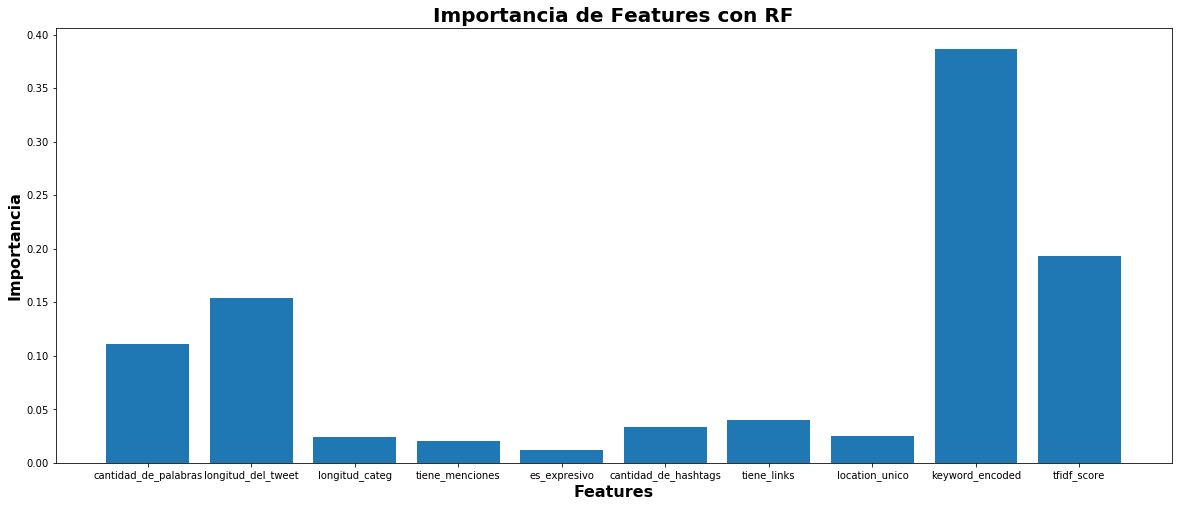

In [46]:
plt.figure(figsize=(20,8))

plt.bar(X.columns, rf_classifier.feature_importances_)

plt.xlabel('Features', fontsize=16, fontweight='bold')
plt.ylabel('Importancia', fontsize=16, fontweight='bold')
plt.title('Importancia de Features con RF', fontsize=20, fontweight='bold')

plt.show()

###### Predicción

In [47]:
registros_a_predecir = test_df.sort_values(by='id',ascending=True).iloc[:,1:]

In [48]:
prediccion = rf_classifier.predict(registros_a_predecir)

Damos el formato para realizar el submit.

In [49]:
resultado_RF = pd.DataFrame(pd.Series(prediccion))
resultado_RF.insert(loc=0, column='id', value=(test_df.sort_values(by='id',ascending=True)['id']))
resultado_RF.rename(columns={0:'target'},inplace=True)
resultado_RF.set_index('id',inplace=True)
resultado_RF['target'] = resultado_RF['target'].astype('uint8')
resultado_RF.head()

,target
id,
0,1
2,1
3,1
9,1
11,1


In [50]:
resultado_RF.to_csv('prediccion_RF.csv')

### XGBoost

In [51]:
from xgboost import XGBClassifier
import xgboost as xgb

In [52]:
xgboost = XGBClassifier(max_depth=1,
              objective= 'binary:logistic',
              nthread=4,n_estimators=2000,
              learning_rate=0.02,
              colsample_bytree=0.75)
xgboost.fit(X_train,Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.75, gamma=0,
              learning_rate=0.02, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=None, n_estimators=2000, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [53]:
Y_pred = xgboost.predict(X_test)

In [54]:
print(classification_report(Y_test,Y_pred))
print(accuracy_score(Y_test,Y_pred))

              precision    recall  f1-score   support

       False       0.78      0.81      0.79       882
        True       0.72      0.68      0.70       641

    accuracy                           0.76      1523
   macro avg       0.75      0.74      0.75      1523
weighted avg       0.75      0.76      0.75      1523

0.7550886408404465


In [55]:
registros_a_predecir = test_df.sort_values(by='id',ascending=True).iloc[:,1:]

In [56]:
prediccion = xgboost.predict(registros_a_predecir)

In [57]:
resultado_XG = pd.DataFrame(pd.Series(prediccion))
resultado_XG.insert(loc=0, column='id', value=(test_df.sort_values(by='id',ascending=True)['id']))
resultado_XG.rename(columns={0:'target'},inplace=True)
resultado_XG.set_index('id',inplace=True)
resultado_XG['target'] = resultado_RF['target'].astype('uint8')
resultado_XG.head()

,target
id,
0,1
2,1
3,1
9,1
11,1


In [58]:
resultado_XG.to_csv('prediccion_XG.csv')

### Redes Neuronales

###### Entrenamiento

Pasamos las variables a categoricas/booleanas a enteros.

In [59]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

train_df['tiene_menciones_int'] = encoder.fit_transform(train_df.tiene_menciones.values)
train_df['es_expresivo_int'] = encoder.fit_transform(train_df.es_expresivo.values)
train_df['location_unico_int'] = encoder.fit_transform(train_df.location_unico.values)
train_df['tiene_link_int'] = encoder.fit_transform(train_df.tiene_links.values)
train_df['target_int'] = encoder.fit_transform(train_df.target.values)

test_df['tiene_menciones_int'] = encoder.fit_transform(test_df.tiene_menciones.values)
test_df['es_expresivo_int'] = encoder.fit_transform(test_df.es_expresivo.values)
test_df['location_unico_int'] = encoder.fit_transform(test_df.location_unico.values)
test_df['tiene_link_int'] = encoder.fit_transform(test_df.tiene_links.values)


In [60]:
train_int = train_df[['cantidad_de_palabras','longitud_del_tweet','longitud_categ','keyword_encoded','tiene_menciones_int','es_expresivo_int','location_unico_int','cantidad_de_hashtags','tfidf_score','tiene_link_int','target']]
test_int = test_df[['cantidad_de_palabras','longitud_del_tweet','longitud_categ','keyword_encoded','tiene_menciones_int','es_expresivo_int','location_unico_int','cantidad_de_hashtags','tfidf_score','tiene_link_int']]

#Sin la columna "tiene link" calculó mejor
X = train_int.iloc[:,:-2]
Y = train_int.iloc[:,-1]

In [61]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2, random_state=1)

In [62]:
#Normalizar
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [63]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(10,10,10), max_iter=500, alpha=0.0001,
                    solver='adam', random_state=5,tol=0.0000001)
mlp.fit(X_train, Y_train)
Y_pred = mlp.predict(X_test)

In [64]:
print(classification_report(Y_test,Y_pred))
print(accuracy_score(Y_test,Y_pred))

              precision    recall  f1-score   support

       False       0.77      0.85      0.81       882
        True       0.76      0.66      0.70       641

    accuracy                           0.77      1523
   macro avg       0.76      0.75      0.75      1523
weighted avg       0.76      0.77      0.76      1523

0.7655942219304005


###### Predicción

In [65]:
registros_a_predecir = test_int.iloc[:,:-1]
registros_a_predecir = scaler.transform(registros_a_predecir)

In [66]:
prediccion = mlp.predict(registros_a_predecir)

Damos el formato para realizar el submit.

In [67]:
resultado_RN = pd.DataFrame(pd.Series(prediccion))
resultado_RN.insert(loc=0, column='id', value=(test_df.sort_values(by='id',ascending=True)['id']))
resultado_RN.rename(columns={0:'target'},inplace=True)
resultado_RN.set_index('id',inplace=True)
resultado_RN['target'] = resultado_RN['target'].astype('uint8')
resultado_RN.head()

,target
id,
0,1
2,0
3,1
9,1
11,1


In [68]:
resultado_RN.to_csv('prediccion_RN.csv')